In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib

In [2]:
# Load feature vector extractor into KerasLayer
# r50x1_loc = "https://tfhub.dev/google/bit/m-r50x1/1"
r50x1_loc = "models/bit_m-r50x1_1"
feat_vec_layer = hub.KerasLayer(r50x1_loc, name='feat_vec_embedding')

In [3]:
def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
  return image

def load_image_from_url(url):
  """Returns an image with shape [1, height, width, num_channels]."""
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

In [4]:
# test feature vector

# Load image
img_url = "https://p0.pikrepo.com/preview/853/907/close-up-photo-of-gray-elephant.jpg"
image = load_image_from_url(img_url)

# Run model on image
logits = feat_vec_layer(image)

In [5]:
logits # 2048-dimensional feature vector

<tf.Tensor: shape=(1, 2048), dtype=float32, numpy=
array([[0.31866187, 0.        , 8.563894  , ..., 0.79412353, 0.53980786,
        6.8815365 ]], dtype=float32)>

In [6]:
# model = tf.keras.Sequential([feat_vec_layer, tf.keras.layers.Dense(2, activation='softmax', kernel_initializer='zeros')])

In [7]:
# class RGB_model(tf.keras.Model):
#   """transfer learning model using feature vector and custom new head"""

#   def __init__(self, num_classes, embedding_layer):
#     super().__init__()

#     self.num_classes = num_classes
#     self.rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
#     self.embedding_layer = embedding_layer
#     self.predict = tf.keras.layers.Dense(num_classes)
  
#   def call(self, images):
#     rescaled = self.rescale(images)
#     img_embedding = self.embedding_layer(rescaled)
#     pred = self.predict(img_embedding)
    
#     return pred

In [8]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

input_shape = [200, 200, 3]
num_classes = 2
input_image = Input(shape=input_shape, name='input_image')
rescaled_image = Rescaling(1./255, name='normalize')(input_image)
image_embedding = feat_vec_layer(rescaled_image)
output = Dense(num_classes, activation='softmax', name='output')(image_embedding)


rgb_model = tf.keras.Model(inputs=[input_image], outputs=[output])

In [9]:
rgb_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 200, 200, 3)]     0         
_________________________________________________________________
normalize (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
feat_vec_embedding (KerasLay (None, 2048)              23500352  
_________________________________________________________________
output (Dense)               (None, 2)                 4098      
Total params: 23,504,450
Trainable params: 4,098
Non-trainable params: 23,500,352
_________________________________________________________________


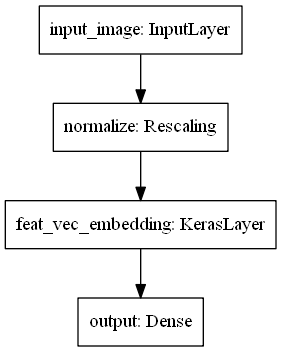

In [10]:
tf.keras.utils.plot_model(rgb_model)

In [11]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

IM_SIZE = (200, 200)
seed = np.random.randint(0, int(1e6))
rgb_train_path = "C:/Users/awnya/Documents/Projects/RGBD Object Classification/RGB_dataset/train"
rgb_dataset_train = image_dataset_from_directory(rgb_train_path, labels='inferred', label_mode='categorical', 
                                                                  image_size=IM_SIZE, batch_size=32, shuffle=True, 
                                                                  validation_split=0.05, subset='training', seed=seed)
rgb_dataset_valid = image_dataset_from_directory(rgb_train_path, labels='inferred', label_mode='categorical', 
                                                                  image_size=IM_SIZE, batch_size=32, shuffle=True, 
                                                                  validation_split=0.05, subset='validation', seed=seed)
                                                                  
rgb_test_path = "C:/Users/awnya/Documents/Projects/RGBD Object Classification/RGB_dataset/test"
rgb_dataset_test = image_dataset_from_directory(rgb_test_path, labels='inferred', label_mode='categorical', 
                                                                  image_size=IM_SIZE, batch_size=32, shuffle=False)

Found 4608 files belonging to 2 classes.
Using 4378 files for training.
Found 4608 files belonging to 2 classes.
Using 230 files for validation.
Found 1316 files belonging to 2 classes.


In [12]:
rgb_dataset_train.class_names

['apple', 'banana']

In [13]:
rgb_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
rgb_model.fit(rgb_dataset_train, epochs=1, steps_per_epoch=5, validation_data=rgb_dataset_valid)

5/5 [==============================] - 76s 12s/step - loss: 1.7522 - accuracy: 0.4878 - val_loss: 0.1144 - val_accuracy: 0.9609


In [15]:
rgb_model.save_weights('weights.h5')

In [17]:
rgb_model.evaluate(rgb_dataset_test)

42/42 [==============================] - 163s 4s/step - loss: 0.2357 - accuracy: 0.9157


[0.23565857112407684, 0.9156534671783447]